<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

2.5.1+cu121


## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. More epochs!!1!!1!
2. Increase model complexity by adding more layers / neurons per layer
2. Find external data to add more features (my fave)

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print("Path exists")
else: 
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path) 

Path exists
Unzipping pizza, steak, suhsi data to data\pizza_steak_sushi


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'), WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'), WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg')]
data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


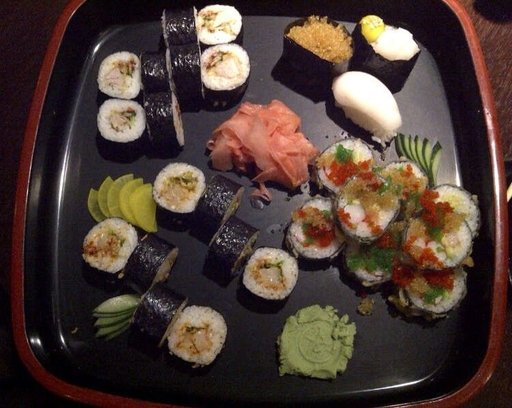

In [7]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

# 2. Get random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

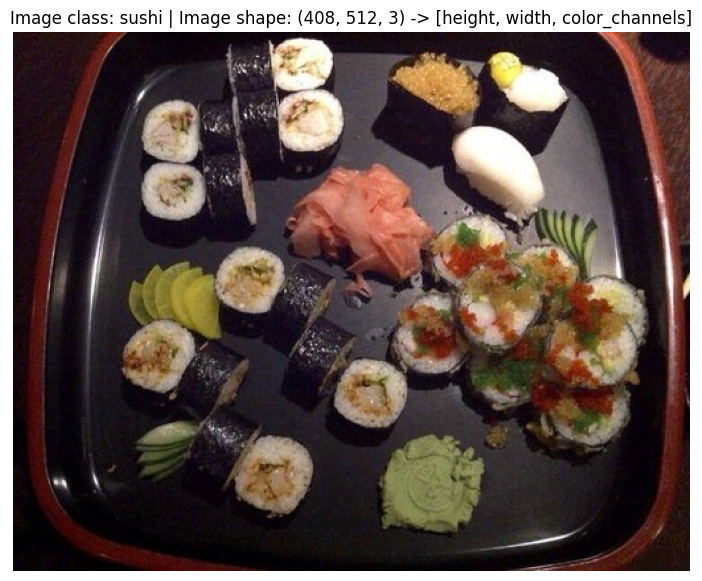

In [8]:
# Do the image visualization with matplotlib
import numpy as np 
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])

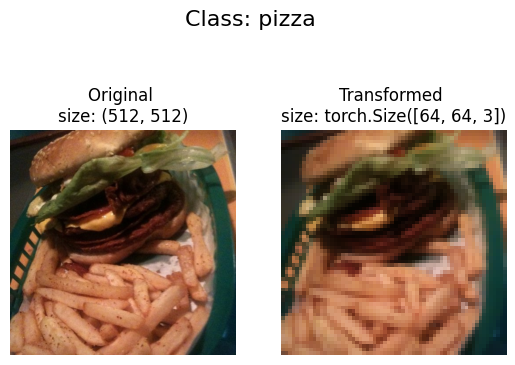

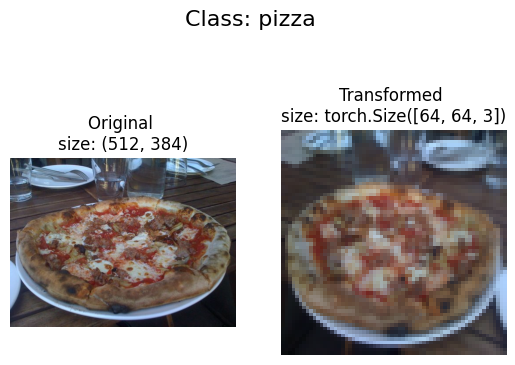

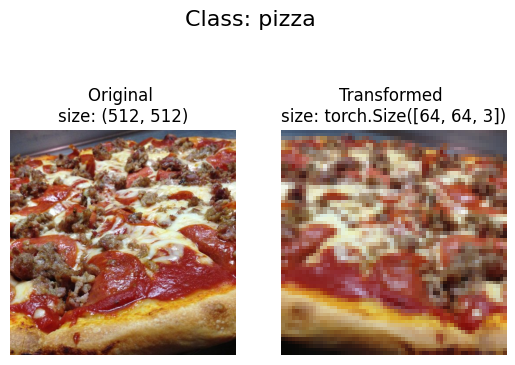

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
#   random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images 
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [19]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

## 4. Create training and testing functions for `model_0`.

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
   

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [22]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

c:\Users\user\Documents\ML\PyTorch_basics\venv_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5 and 20 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [23]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

 20%|██        | 1/5 [00:25<01:41, 25.39s/it]

Epoch: 1 | train_loss: 1.1180 | train_acc: 0.2933 | test_loss: 1.0965 | test_acc: 0.3333


 40%|████      | 2/5 [00:51<01:17, 25.89s/it]

Epoch: 2 | train_loss: 1.1001 | train_acc: 0.3111 | test_loss: 1.0994 | test_acc: 0.2533


 60%|██████    | 3/5 [01:17<00:52, 26.03s/it]

Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2978 | test_loss: 1.0997 | test_acc: 0.3333


 80%|████████  | 4/5 [01:42<00:25, 25.41s/it]

Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3289 | test_loss: 1.1000 | test_acc: 0.3333


100%|██████████| 5/5 [02:09<00:00, 25.90s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3333 | test_loss: 1.1004 | test_acc: 0.3333


In [24]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:27<08:33, 27.05s/it]

Epoch: 1 | train_loss: 1.1180 | train_acc: 0.2933 | test_loss: 1.0965 | test_acc: 0.3333


 10%|█         | 2/20 [00:51<07:43, 25.77s/it]

Epoch: 2 | train_loss: 1.1001 | train_acc: 0.3111 | test_loss: 1.0994 | test_acc: 0.2533


 15%|█▌        | 3/20 [01:16<07:06, 25.08s/it]

Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2978 | test_loss: 1.0997 | test_acc: 0.3333


 20%|██        | 4/20 [01:40<06:39, 24.94s/it]

Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3289 | test_loss: 1.1000 | test_acc: 0.3333


 25%|██▌       | 5/20 [02:12<06:48, 27.23s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3333 | test_loss: 1.1004 | test_acc: 0.3333


 30%|███       | 6/20 [02:41<06:29, 27.80s/it]

Epoch: 6 | train_loss: 1.1032 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333


 35%|███▌      | 7/20 [03:06<05:50, 27.00s/it]

Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333


 40%|████      | 8/20 [03:43<06:03, 30.29s/it]

Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333


 45%|████▌     | 9/20 [04:14<05:34, 30.42s/it]

Epoch: 9 | train_loss: 1.0991 | train_acc: 0.3289 | test_loss: 1.1018 | test_acc: 0.3333


 50%|█████     | 10/20 [05:04<06:05, 36.55s/it]

Epoch: 10 | train_loss: 1.0998 | train_acc: 0.3600 | test_loss: 1.1013 | test_acc: 0.3333


 55%|█████▌    | 11/20 [05:40<05:25, 36.15s/it]

Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1019 | test_acc: 0.3333


 60%|██████    | 12/20 [06:13<04:42, 35.37s/it]

Epoch: 12 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


 65%|██████▌   | 13/20 [06:47<04:03, 34.78s/it]

Epoch: 13 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1018 | test_acc: 0.3333


 70%|███████   | 14/20 [07:24<03:32, 35.46s/it]

Epoch: 14 | train_loss: 1.0992 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333


 75%|███████▌  | 15/20 [07:59<02:56, 35.32s/it]

Epoch: 15 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


 80%|████████  | 16/20 [08:36<02:23, 35.94s/it]

Epoch: 16 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.1026 | test_acc: 0.3333


 85%|████████▌ | 17/20 [09:10<01:46, 35.43s/it]

Epoch: 17 | train_loss: 1.0982 | train_acc: 0.3333 | test_loss: 1.1023 | test_acc: 0.3333


 90%|█████████ | 18/20 [09:48<01:12, 36.29s/it]

Epoch: 18 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333


 95%|█████████▌| 19/20 [10:24<00:36, 36.03s/it]

Epoch: 19 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


100%|██████████| 20/20 [10:58<00:00, 32.94s/it]

Epoch: 20 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [25]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:34<10:52, 34.36s/it]

Epoch: 1 | train_loss: 1.0967 | train_acc: 0.3822 | test_loss: 1.0740 | test_acc: 0.3333


 10%|█         | 2/20 [01:10<10:33, 35.18s/it]

Epoch: 2 | train_loss: 1.0241 | train_acc: 0.5333 | test_loss: 1.0876 | test_acc: 0.4400


 15%|█▌        | 3/20 [01:45<09:58, 35.19s/it]

Epoch: 3 | train_loss: 0.9762 | train_acc: 0.5511 | test_loss: 0.9979 | test_acc: 0.5200


 20%|██        | 4/20 [02:19<09:14, 34.65s/it]

Epoch: 4 | train_loss: 0.8926 | train_acc: 0.6000 | test_loss: 1.0229 | test_acc: 0.5067


 25%|██▌       | 5/20 [02:55<08:50, 35.39s/it]

Epoch: 5 | train_loss: 0.8640 | train_acc: 0.6222 | test_loss: 1.1467 | test_acc: 0.4667


 30%|███       | 6/20 [03:37<08:44, 37.47s/it]

Epoch: 6 | train_loss: 0.8413 | train_acc: 0.6356 | test_loss: 0.9560 | test_acc: 0.4667


 35%|███▌      | 7/20 [04:18<08:23, 38.74s/it]

Epoch: 7 | train_loss: 0.8431 | train_acc: 0.6533 | test_loss: 1.0691 | test_acc: 0.4800


 40%|████      | 8/20 [05:06<08:17, 41.49s/it]

Epoch: 8 | train_loss: 0.7625 | train_acc: 0.6667 | test_loss: 1.0085 | test_acc: 0.4800


 45%|████▌     | 9/20 [05:50<07:47, 42.54s/it]

Epoch: 9 | train_loss: 0.7491 | train_acc: 0.6844 | test_loss: 1.0192 | test_acc: 0.4533


 50%|█████     | 10/20 [06:25<06:41, 40.13s/it]

Epoch: 10 | train_loss: 0.7225 | train_acc: 0.7067 | test_loss: 1.1415 | test_acc: 0.4267


 55%|█████▌    | 11/20 [06:58<05:40, 37.88s/it]

Epoch: 11 | train_loss: 0.7053 | train_acc: 0.6889 | test_loss: 0.9850 | test_acc: 0.4800


 60%|██████    | 12/20 [07:31<04:51, 36.44s/it]

Epoch: 12 | train_loss: 0.6554 | train_acc: 0.7111 | test_loss: 1.5014 | test_acc: 0.4667


 65%|██████▌   | 13/20 [08:07<04:13, 36.26s/it]

Epoch: 13 | train_loss: 0.6067 | train_acc: 0.7200 | test_loss: 1.3158 | test_acc: 0.4933


 70%|███████   | 14/20 [08:46<03:42, 37.09s/it]

Epoch: 14 | train_loss: 0.6149 | train_acc: 0.7378 | test_loss: 1.1703 | test_acc: 0.5333


 75%|███████▌  | 15/20 [09:24<03:07, 37.40s/it]

Epoch: 15 | train_loss: 0.5453 | train_acc: 0.7822 | test_loss: 1.5381 | test_acc: 0.5200


 80%|████████  | 16/20 [10:05<02:33, 38.38s/it]

Epoch: 16 | train_loss: 0.5731 | train_acc: 0.7511 | test_loss: 1.6744 | test_acc: 0.4933


 85%|████████▌ | 17/20 [10:48<01:59, 39.92s/it]

Epoch: 17 | train_loss: 0.4981 | train_acc: 0.8089 | test_loss: 1.5429 | test_acc: 0.5467


 90%|█████████ | 18/20 [11:25<01:17, 38.99s/it]

Epoch: 18 | train_loss: 0.3962 | train_acc: 0.8222 | test_loss: 1.9229 | test_acc: 0.5200


 95%|█████████▌| 19/20 [12:01<00:38, 38.18s/it]

Epoch: 19 | train_loss: 0.4602 | train_acc: 0.8133 | test_loss: 1.4446 | test_acc: 0.4933


100%|██████████| 20/20 [12:37<00:00, 37.85s/it]

Epoch: 20 | train_loss: 0.3430 | train_acc: 0.8667 | test_loss: 2.0695 | test_acc: 0.4667


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [26]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [27]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [28]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [29]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)


# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)


In [30]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        epochs=20)

  5%|▌         | 1/20 [00:34<10:51, 34.30s/it]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3312 | test_loss: 1.1004 | test_acc: 0.2875


 10%|█         | 2/20 [01:10<10:33, 35.17s/it]

Epoch: 2 | train_loss: 1.0834 | train_acc: 0.3917 | test_loss: 1.0691 | test_acc: 0.4102


 15%|█▌        | 3/20 [01:42<09:33, 33.75s/it]

Epoch: 3 | train_loss: 1.0270 | train_acc: 0.4500 | test_loss: 0.9526 | test_acc: 0.5659


 20%|██        | 4/20 [02:12<08:35, 32.22s/it]

Epoch: 4 | train_loss: 0.9194 | train_acc: 0.5583 | test_loss: 0.9057 | test_acc: 0.5938


 25%|██▌       | 5/20 [02:42<07:54, 31.62s/it]

Epoch: 5 | train_loss: 0.8564 | train_acc: 0.6604 | test_loss: 0.9187 | test_acc: 0.5085


 30%|███       | 6/20 [03:07<06:50, 29.33s/it]

Epoch: 6 | train_loss: 0.8279 | train_acc: 0.6521 | test_loss: 1.0182 | test_acc: 0.4966


 35%|███▌      | 7/20 [03:30<05:54, 27.25s/it]

Epoch: 7 | train_loss: 0.8911 | train_acc: 0.5833 | test_loss: 0.8895 | test_acc: 0.5557


 40%|████      | 8/20 [03:47<04:47, 23.93s/it]

Epoch: 8 | train_loss: 0.7661 | train_acc: 0.6729 | test_loss: 0.8844 | test_acc: 0.6136


 45%|████▌     | 9/20 [04:03<03:57, 21.55s/it]

Epoch: 9 | train_loss: 0.7819 | train_acc: 0.6458 | test_loss: 0.8937 | test_acc: 0.5750


 50%|█████     | 10/20 [04:20<03:20, 20.00s/it]

Epoch: 10 | train_loss: 0.7731 | train_acc: 0.6792 | test_loss: 0.8544 | test_acc: 0.6409


 55%|█████▌    | 11/20 [04:36<02:48, 18.76s/it]

Epoch: 11 | train_loss: 0.7308 | train_acc: 0.6646 | test_loss: 0.8575 | test_acc: 0.6188


 60%|██████    | 12/20 [04:51<02:22, 17.81s/it]

Epoch: 12 | train_loss: 0.6879 | train_acc: 0.7229 | test_loss: 0.8385 | test_acc: 0.6500


 65%|██████▌   | 13/20 [05:07<02:00, 17.20s/it]

Epoch: 13 | train_loss: 0.6004 | train_acc: 0.7312 | test_loss: 0.9396 | test_acc: 0.5778


 70%|███████   | 14/20 [05:23<01:40, 16.79s/it]

Epoch: 14 | train_loss: 0.5696 | train_acc: 0.7562 | test_loss: 1.0803 | test_acc: 0.5705


 75%|███████▌  | 15/20 [05:39<01:22, 16.48s/it]

Epoch: 15 | train_loss: 0.5414 | train_acc: 0.7729 | test_loss: 1.0129 | test_acc: 0.6080


 80%|████████  | 16/20 [05:54<01:04, 16.23s/it]

Epoch: 16 | train_loss: 0.5369 | train_acc: 0.7854 | test_loss: 1.0574 | test_acc: 0.5233


 85%|████████▌ | 17/20 [06:10<00:48, 16.04s/it]

Epoch: 17 | train_loss: 0.5256 | train_acc: 0.7521 | test_loss: 1.1757 | test_acc: 0.5341


 90%|█████████ | 18/20 [06:25<00:31, 15.87s/it]

Epoch: 18 | train_loss: 0.4529 | train_acc: 0.8187 | test_loss: 1.0235 | test_acc: 0.5778


 95%|█████████▌| 19/20 [06:41<00:15, 15.73s/it]

Epoch: 19 | train_loss: 0.4054 | train_acc: 0.8458 | test_loss: 1.1129 | test_acc: 0.5818


100%|██████████| 20/20 [06:56<00:00, 20.83s/it]

Epoch: 20 | train_loss: 0.3670 | train_acc: 0.8771 | test_loss: 1.1870 | test_acc: 0.6193


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [32]:
custom_image = "pizza.jpg"
with open("pizza.jpg", "wb") as f:
  request = requests.get("https://assets.surlatable.com/m/15a89c2d9c6c1345/72_dpi_webp-REC-283110_Pizza.jpg")
  f.write(request.content)

In [33]:
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[48, 52, 57,  ...,  3,  3,  5],
         [49, 51, 50,  ...,  2,  4,  3],
         [49, 43, 36,  ...,  2,  6,  5],
         ...,
         [21, 17, 17,  ..., 12, 12, 11],
         [18, 17, 17,  ...,  9,  9, 11],
         [15, 18, 16,  ..., 13, 12, 15]],

        [[49, 53, 58,  ...,  3,  3,  4],
         [50, 52, 51,  ...,  2,  4,  2],
         [50, 44, 37,  ...,  2,  6,  5],
         ...,
         [21, 17, 17,  ..., 12, 12, 11],
         [18, 17, 17,  ...,  9,  9, 11],
         [15, 18, 16,  ..., 13, 12, 15]],

        [[53, 57, 62,  ...,  3,  5,  9],
         [55, 57, 56,  ...,  2,  6,  7],
         [54, 48, 42,  ...,  4,  8,  7],
         ...,
         [23, 17, 17,  ..., 12, 12, 11],
         [20, 17, 17,  ..., 11,  9,  9],
         [15, 18, 16,  ..., 15, 12, 15]]], dtype=torch.uint8)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

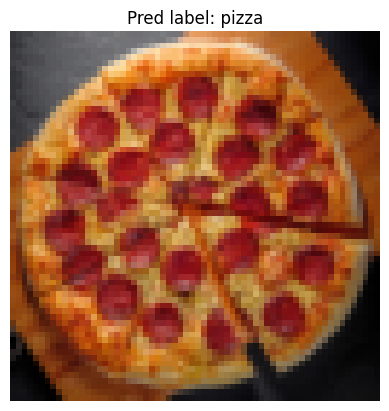

In [34]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False)